# Computational analysis

<div class="alert alert-block alert-info">
    
<b>QUESTION:</b> Using the Aqueduct data layers, estimate the number of people vulnerable to riverine flooding in Kenya, comparing the historical baseline against the RCP8.5 2080 projection from the HadGEM2-ES model for a 1-in-in-1000-year event. Produce a set of plots showing the results and discuss the findings. Please provide the associated code with relevant annotations and numpy docstrings explaining the code. Write the analysis code in the PEP8 style.

</div>

For this analysis, three datasets are required. These are;

 1. Kenya boundary shapefile
 2. Kenya Population count by spatial distribution
 3. Riverine flooding data

We will need some packages to get started.

In [33]:
import os                 # for basic operating system functions
import json
import rasterio
import warnings
import contextily as cx
import geopandas as gpd   # For working with geospatial dataframes
import matplotlib.pyplot as plt
import pandas as pd       # To load .csv data as a dataframe
import seaborn as sns
from rasterio.mask import mask
#from rasterstats import zonal_stats
from shapely.geometry import MultiPolygon
warnings.filterwarnings('ignore')

In [101]:
filename = 'gadm_1.shp'
path_in = os.path.join('data', 'processed', 'RWA', 'regions', filename) 

filename2 = 'population.csv'
path_2 = os.path.join('data', 'processed', 'RWA', filename2) 
data = pd.read_csv(path_2)

boundaries = country_boundaries.merge(data, left_on = 'GID_0', right_on = 'GID_1')
bins = [-1e6, 300000, 350000, 400000, 450000, 1e12]
labels = ['<2k','2-4k','4-6k','6-8k','>8k']
     
boundaries['bin'] = pd.cut(boundaries['population'], bins = bins, labels = labels)  

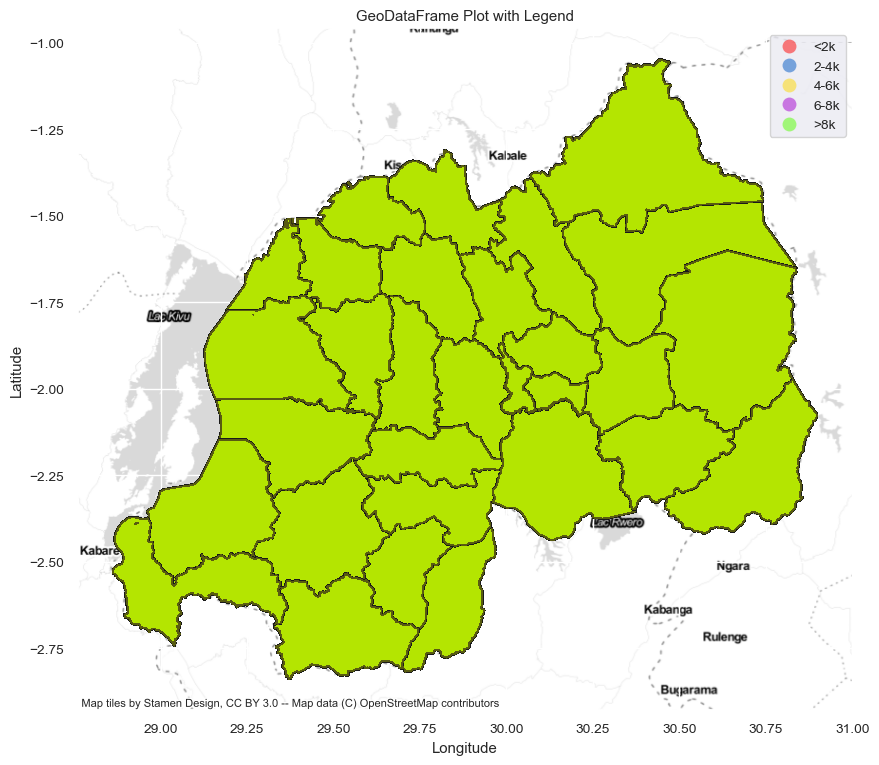

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometry column with a legend based on 'column_name'
boundaries.plot(column='bin', cmap = 'prism', ax = ax, alpha=0.5, edgecolor='k', legend = True, antialiased = False)

# Add background map tiles using contextily
cx.add_basemap(ax, crs=boundaries.crs.to_string(), source=cx.providers.Stamen.TonerLite)

# Set plot title and labels if desired
ax.set_title('GeoDataFrame Plot with Legend')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

## 1. Process Kenya boundary 

First we obtain a csv country metadafile containing information about 250 territories and store it in a data directory

Next we create a function that read the country of interest, process the boundary information and store it in a folder named by the country's **"ISO3"** code as well as create regions subfolder to contain the processed shapefiles. For instance, Kenya will be **"KEN"**

In [ ]:
metadata_file = os.path.join('data', 'countries.csv')

In [ ]:
def country_directory(csv_filename, country_iso3):
    """
    Create country folder and regions subfolder within it.
    
    Parameters
    ----------
    csv_filename : string
        Name of the country metadata file.
    country_iso3 : string
        Country iso3 to be processed.
        
    Returns
    -------
    output : list
        List containing country ISO3 and gid_region
    """
    countries = pd.read_csv(csv_filename, encoding = 'latin-1')
    
    output = []
    
    for idx, country in countries.iterrows():
        
        if not country['iso3'] == country_iso3: #If the current country iso3 does not match the entered iso3...
            continue                            #continue in the loop to the next country
            
        iso3 = country['iso3']
        gid_region = country['gid_region']
        country_name = country['country']
        
        output.append(iso3)
        output.append(gid_region)
        
        country_folder_path = os.path.join('data', 'processed', iso3) #Create folder called "processed" to store
        if not os.path.exists(country_folder_path):                   #country folder
            os.makedirs(country_folder_path)                          #Onle create folder if it doest exist already
            
        regions_folder_path = os.path.join('data', 'processed', iso3, 'regions') #Create regions folder within
        if not os.path.exists(regions_folder_path):
            os.makedirs(regions_folder_path)
            
        print('processing {}'.format(country_name))      
    
    return output

We then use the function to create the folder for Kenya

In [ ]:
country_directory(metadata_file, 'COD')

Next we download global administrative maps data from https://gadm.org/download_world.html for the whole world. The current GADM version is 4.1 consisting of 400,276 administrative areas globally.

The data is downloaded as a single database in GeoPackage format and stored in the folder called **"raw"**

We then specify the location of the data

In [ ]:
boundary_data = os.path.join('data', 'raw', 'gadm36_2.shp') 

We create a function that read the global administrative boundaries, select a country that we specify using the **"ISO3"** code process the boundaries and store in the corresponding folder.  

In [ ]:
country_directory(metadata_file, 'COD')

In [ ]:
def country_boundary(boundary_data_path, country_iso3, gid_level):
    """
    Process country shapefile.
    
    Parameters
    ----------
    boundary_data_path : string
        Location of the GADM boundary data.
    country_iso3 : string
        Country iso3 to be processed.
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    none  
    """
    global_boundaries = gpd.read_file(boundary_data_path)
    
    iso3 = country_directory(metadata_file, country_iso3)[0]
    gid_region = country_directory(metadata_file, country_iso3)[1]
    
    country_boundaries = global_boundaries[global_boundaries[gid_level] == iso3]
    gid_level_name = country_boundaries['NAME_1']
    
    filename = 'gadm_{}.shp'.format(gid_region)
    path_out = os.path.join('data', 'processed', iso3, 'regions', filename)
    country_boundaries.to_file(path_out)
    
    print('processing {}'.format(gid_level_name))
    
    return None

We then apply our function for Kenya, (*'ISO3'* = *'KEN'*)

In [ ]:
country_boundary(boundary_data, 'COD', 'GID_0')

## 2. Kenya Population count by spatial distribution

Next, we need to download and process population data

The population count data is downloaded from WorldPop website (https://hub.worldpop.org/geodata/listing?id=64). 

The data downloaded is the unconstrained global mosaics 2000-2020 for 2020. The layer represent the estimated total number of people per grid-cell, in Geotiff format at a resolution of 30 arc (approximately 1km at the equator), in the WGS84 Geographic Coordinate System.

The downloaded data is stored in the *"raw"* folder.

We specify the location of the data and load the layer to raster input-output (rasterio) object

#### Preliminary data check 

These set of cells are just to ensure that both the data layers are working properly as well as checking out their contents.

In [ ]:
filename = 'ppp_2020_1km_Aggregated.tif'
folder = os.path.join('data', 'raw', 'worldpop')
path_population = os.path.join(folder, filename)

my_raster_image = rasterio.open(path_population)
my_raster_image

We can then access the Python API interface for the .tif population layer file based on the Numpy N-dimensional arrays

<div class="alert alert-block alert-warning">

<b>!! Attention !!</b> This my take long since it is loading the whole world!.

</div>

In [ ]:
data = my_raster_image.read(1)
print(data)

We now query our population raster layer using the Kenyan boundary shapefile processed in section 1.

Let us load the processed Kenyan shapefile

In [ ]:
filename = 'gadm_1.shp'
path_boundary = os.path.join('data', 'processed', 'COD', 'regions', filename)
boundaries = gpd.read_file(path_boundary, crs = 'epsg:4326')
boundaries

#### Process Kenyan population layer

We now write a function that load the data layer, affine function, eliminate negative cell numbers, sum all the cells within the boundary of interest and return a csv file for plotting.

In [ ]:
def process_population_tif(data_name, grid_level):
    """
    Process population layer.
    
    Parameters
    ----------
    data_name: string
        Filename of the population raster layer
    gid_level: string
        GID boundary spatial level to process
        
    Returns
    -------
    output: dictionary.
        Dictionary containing the country population and grid level
    """
    output = []
    for idx, boundary in boundaries.iterrows():
        
        print('Working on {}'.format(boundary['NAME_1']))
        
        with rasterio.open(data_name) as src:
            
            affine = src.transform
            array = src.read(1)
            array[array <= 0] = 0
            
            population = [i['sum'] for i in zonal_stats(
                boundary['geometry'], array, nodata = 255,
                stats = ['sum'], affine = affine)][0]
            output.append({
                'NAME_1': boundary['NAME_1'],
                'GID_1': boundary[grid_level],
                'population': population
            })
            
    return output

We now apply the function to our population layer

In [ ]:
filename = 'ppp_2020_1km_Aggregated.tif'
folder = os.path.join('data', 'raw', 'worldpop')
path_population = os.path.join(folder, filename)
pop = process_population_tif(path_population, 'GID_1')

And then we store our results as csv file in the *processed/KEN* folder

In [ ]:
pop_results = pd.DataFrame(pop)
path_out = os.path.join('data', 'processed', 'COD', 'population.csv')
pop_results.to_csv(path_out)

In [ ]:
path_out = os.path.join('data', 'processed', 'COD', 'population.csv')
pop_results = pd.read_csv(path_out, 'population.csv')

#### Plotting population map 

First, we import country boundary.

In [23]:
#import our boundaries data
filename = 'gadm_1.shp'.format(1)
path_in = os.path.join('data', 'processed', 'COD', 'regions', filename) 
country_boundaries = gpd.read_file(path_in)

And then we import the previously-saved population csv file.

In [24]:
#import our population data
filename = 'population.csv'
path_in = os.path.join('data', 'processed', 'COD', filename) 
data = pd.read_csv(path_in)

We then write a function to plot the data.

<div class="alert alert-block alert-info">
    
<b>Note:</b> You need to manually adjust the bins and labels inside the function depending on the distribution of your dataset.

</div>

In [103]:
def plot_population(country_boundaries, csv_data, gid_level, iso3):
    """
    Plots the country's population at sub-region level.
    
    Parameters
    ----------
    country_boundaries : string
        Name of the country boundary .shp file
    csv_data : string
        Name of the csv file containing the population data
        at sub-regional level
    gid_level : string
        Name of the GID level
    country_iso3 = string
        ISO3 of the country
    
    Return
    ------
    fig : python object
        A map of population distribution. 
    """
    boundaries = country_boundaries.merge(csv_data, left_on = 'GID_0', #merge our population data onto our boundaries
                                  right_on = gid_level)
    
    bins = [5000, 100000, 150000, 300000, 400000, 500000,        #define value bins and then labels for each one
            600000, 700000, 800000, 900000, 1000000]
    labels = ['<300k', '300-320k','320-340k','340-360k','360-380k', '400-420k', 
              '420-440k', '440-460k', '460-480k', '480-500k']
     
    boundaries['bin'] = pd.cut(                                   #create a new variable with our bin labels
        boundaries['population'], 
        bins = bins,
        labels = labels
    )   
    
    sns.set(font_scale = 0.9)                                     #open a new seaborn figure
    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    base = boundaries.plot(column = 'bin', ax = ax,               #now plot our data using pandas plot
                           cmap = 'copper', linewidth = 0, 
                           legend = True, antialiased = False)
    #allocate a plot title 
    n = len(boundaries)
    name = 'COD Population by Sub-Region(n={})'.format(n)
    fig.suptitle(name)
    
    path = os.path.join('data', 'processed', iso3, 'drc_population.png')
    fig.savefig(path)
    plt.close(fig)

    fig
    
    return fig

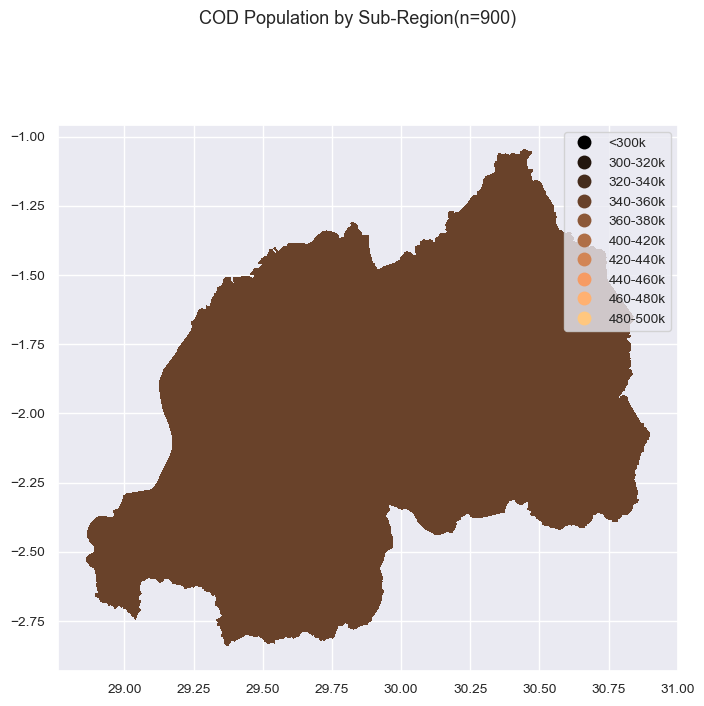

In [104]:
plot_population(country_boundaries, data, 'GID_1', 'RWA')

## 3. Kenya riverine flood layer

Lastly we need to process riverine flooding data and intersect it with the Kenyan population that are vulnerable to it.

First we need to download the flodding layers data from the World Resources Institute (WRI).

As per the instructions, .tif riverine flood layer of the HadGEM2-ES model, for the RCP8.5 projection to 2080, and a return period of 1-in-1000 years (thus, an annual probability of occurrence of 0.01%) and historical baseline layer is downloaded.

The data is stored in the *flood_hazard* directory under *data/raw/*

To process the flooding layers, we will use the mask function in rasterio. The mask function works by only including cell values within the specified boundary (in this case Kenyan boundary) and excludes those outside the polygon. 

Read the country metadata file

In [3]:
countries = pd.read_csv(metadata_file, encoding = 'latin-1')
countries.head()

,iso3,iso2,country,continent,gid_region,lowest,Exclude,Population,income_group,flood_region
0,ABW,AW,Aruba,North America,0,0,1,"107,195",HIC,South America
1,AFG,AF,Afghanistan,Asia,2,2,0,"39,835,428",LIC,South Asia
2,AGO,AO,Angola,Africa,2,2,0,"33,933,611",LMC,Sub-Saharan Africa
3,AIA,AI,Anguilla,North America,0,0,1,-,-,Central America & Caribbean
4,ALA,AX,Åland Islands,Europe,2,2,1,-,-,Western Europe


We then loop through the countries dataframe and only pick the geometry for Kenya.

We then load then load the flooding layers, create a new geodatafarme for each sub-region, clip the regions with the musk function and then write the resulting files as .tif.

The whole code is shown below

In [4]:
for idx, country in countries.iterrows():

    if not country['iso3'] == 'COD': 
        continue   
    
    #define our country-specific parameters, including gid information
    iso3 = country['iso3']
    gid_region = country['gid_region']
    gid_level = 'GID_{}'.format(gid_region)
    
    #set the filename depending our preferred regional level
    filename = "gadm_{}.shp".format(gid_region)
    folder = os.path.join('data','processed', iso3, 'regions')
    
    #then load in our regions as a geodataframe
    path_regions = os.path.join(folder, filename)
    regions = gpd.read_file(path_regions, crs = 'epsg:4326')#[:2]
    
    for idx, region in regions.iterrows():

        #get our gid id for this region 
        #(which depends on the country-specific gid level)
        gid_id = region[gid_level]
        
        print('----Working on {}'.format(gid_id))
        
        #let's load in our hazard layer
        filename = 'inunriver_rcp8p5_0000HadGEM2-ES_2080_rp00100.tif'
        path_hazard = os.path.join('data','raw','flood_hazard', filename)
        hazard = rasterio.open(path_hazard, 'r+')
        hazard.nodata = 255                       #set the no data value
        hazard.crs.from_epsg(4326)                #set the crs

        #create a new gpd dataframe from our single region geometry
        geo = gpd.GeoDataFrame(gpd.GeoSeries(region.geometry))
        #this line sets geometry for resulting geodataframe
        geo = geo.rename(columns = {0:'geometry'}).set_geometry('geometry')
        #convert to json
        coords = [json.loads(geo.to_json())['features'][0]['geometry']] 
        
        #carry out the clip using our mask
        out_img, out_transform = mask(hazard, coords, crop = True)
        out_img, out_transform

        #update our metadata
        out_meta = hazard.meta.copy()
        out_meta.update({"driver": "GTiff",
                        "height": out_img.shape[1],
                        "width": out_img.shape[2],
                        "transform": out_transform,
                        "crs": 'epsg:4326'})

        #now we write out at the regional level
        filename_out = '{}.tif'.format(gid_id) #each regional file is named using the gid id
        folder_out = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'tifs')
        if not os.path.exists(folder_out):
            os.makedirs(folder_out)
        path_out = os.path.join(folder_out, filename_out)

        with rasterio.open(path_out, "w", **out_meta) as dest:
            dest.write(out_img)
    print('--')
    print('Processing complete for {}'.format(iso3))

----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.1_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.2_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.3_1
----Working on COD.4_1
----Working on COD.4_1
----Working on COD.4_1
----Working on COD.4_1
----Working on COD.4_1
----Working on COD.4_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working on COD.5_1
----Working

Now we have processed and generated the *.tif* files for all the sub-regions in Kenya. We then write a loop to read all the *.tif* files from the directory

In [5]:
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'tifs') #Folder location
lists = os.listdir(folder) 
for tifs in os.listdir(folder):
    if tifs.endswith('.tif'):
        tifs = os.path.splitext(tifs)[0]

Now we that we have our .tif read, we can use this code  to convert your raster file into a shapefile

In [6]:
for tifs in os.listdir(folder):
    try:
        if tifs.endswith('.tif'):
            tifs = os.path.splitext(tifs)[0]

            folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'tifs')
            filename = tifs + '.tif'
            
            path_in = os.path.join(folder, filename)

            folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'shapefiles')
            if not os.path.exists(folder):
                os.mkdir(folder)
                
            filename = tifs + '.shp'
            path_out = os.path.join(folder, filename)

            with rasterio.open(path_in) as src:

                affine = src.transform
                array = src.read(1)

                output = []

                for vec in rasterio.features.shapes(array):

                    if vec[1] > 0 and not vec[1] == 255:

                        coordinates = [i for i in vec[0]['coordinates'][0]]

                        coords = []

                        for i in coordinates:

                            x = i[0]
                            y = i[1]

                            x2, y2 = src.transform * (x, y)

                            coords.append((x2, y2))

                        output.append({
                            'type': vec[0]['type'],
                            'geometry': {
                                'type': 'Polygon',
                                'coordinates': [coords],
                            },
                            'properties': {
                                'value': vec[1],
                            }
                        })

            output = gpd.GeoDataFrame.from_features(output, crs = 'epsg:4326')
            output.to_file(path_out, driver = 'ESRI Shapefile')
    except:
        pass

We then read all the shapefiles and then combine them to single one.

In [7]:
for shapefiles in os.listdir(folder):
    if shapefiles.endswith('.shp'):
        shapefiles = os.path.splitext(shapefiles)[0]

In [8]:
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'shapefiles')

# Create an empty geodataframe to hold the combined data
combined_gdf = gpd.GeoDataFrame()

for shapefiles in os.listdir(folder):
    
    if shapefiles.endswith('.shp'):
        
        filepath = os.path.join(folder, shapefiles)
        
        # Read the shapefile and add it to the combined dataframe
        gdf = gpd.read_file(filepath)
        combined_gdf = combined_gdf.append(gdf, ignore_index = True)
        
filename = 'inunriver_rcp8p5_0000HadGEM2-ES_2080_rp00100.shp' #Name of the shapefile
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver') 
path_out = os.path.join(folder, filename)       

combined_gdf.to_file(path_out, driver = 'ESRI Shapefile')

#### Plotting the Flood Layers 

We load the saved combined shapefile

In [9]:
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver')
filename = 'inunriver_rcp8p5_0000HadGEM2-ES_2080_rp00100.shp'
path_in = os.path.join(folder, filename)
path_in

'data/processed/COD/hazards/inunriver/inunriver_rcp8p5_0000HadGEM2-ES_2080_rp00100.shp'

And then we plot the flood layers using Openstreet as a basemap

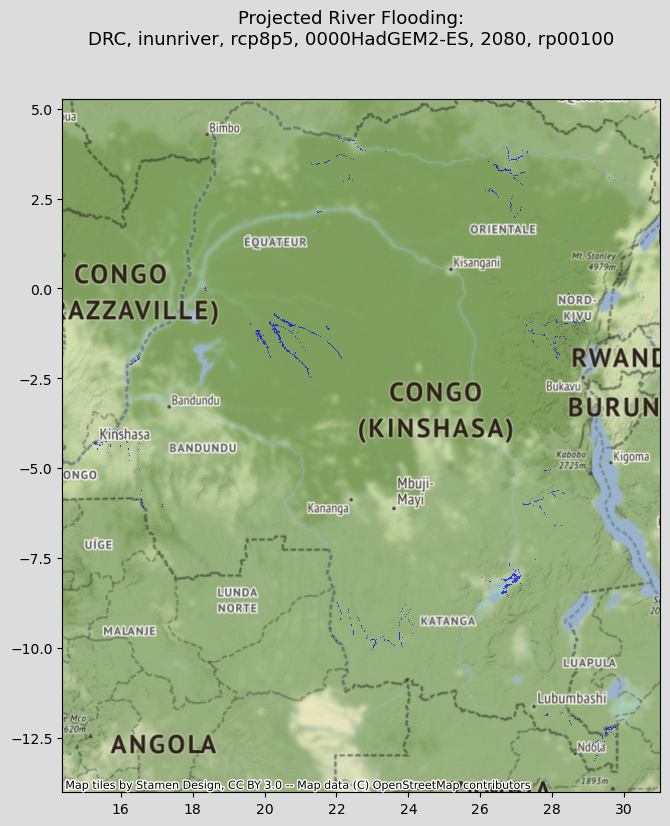

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 9)) 
fig.set_facecolor('gainsboro')

# Import hazard and plot 
hazard = gpd.read_file(path_in) 
hazard.plot(color = 'blue', linewidth = 1.5, alpha = .7, legend = True, edgecolor = None, ax = ax)

cx.add_basemap(ax, crs = 'epsg:4326') #add the map baselayer

# Subset scenario strings for title
hazard_type = filename.split('_')[0]
scenario = filename.split('_')[1]
model = filename.split('_')[2]
year = filename.split('_')[3]
return_period = filename.split('_')[4]
return_period = return_period.replace('.shp', '')

# Insert scenario strings in title
main_title = 'Projected River Flooding:\n{}, {}, {}, {}, {}, {}'.format(
    'DRC', hazard_type, scenario, model, year, return_period
)
plt.suptitle(main_title, fontsize = 13, wrap = True)

path = os.path.join('data', 'processed', iso3, 'drc_flood_hadgem_100_model.png')
fig.savefig(path)
plt.close(fig)
fig

## Overlaying of the Datasets 

This last step involves combining the population and flooding data to know the spatial distribution of people who are vulnerable to the hazard.

We first merge the population data with the boundary data and then perform a spatial intersection overlay operation to know the number of vulnerable people in the flooded regions.

First we import the population dataset.

In [13]:
filename = 'population.csv'
path_in = os.path.join('data', 'processed', 'COD', filename) 
data = pd.read_csv(path_in)

And then import the previously processed  boundaries dataset.

In [14]:
filename = 'gadm_{}.shp'.format(1)
path_in = os.path.join('data', 'processed', 'COD', 'regions', filename) 
country_boundaries = gpd.read_file(path_in)

We then merge the boundary dataset with population dataset and confirm the projection.

In [15]:
pop_bound = country_boundaries.merge(data, left_on='GID_1', right_on='GID_1')
pop_bound.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We save the population dataset as a shapefile for future use.

In [16]:
%time
filename = 'rcp8p5_100_population_boundary.shp' #Name of the shapefile
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'intersections') 
if not os.path.exists(folder):
    os.makedirs(folder)
    
path_out = os.path.join(folder, filename)       
pop_bound.to_file(path_out, driver = 'ESRI Shapefile')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


Finally, we overlay the flooding data to the merged dataset by intersection using geopandas library's overlay function.

We also calculate the number of people within the intersected regions and save the results as a csv file.

In [17]:
#Intersect the two dataframes
intersection = gpd.overlay(pop_bound, combined_gdf, how = 'intersection')


First we save the intersected dataframe as a shapefile for future use

In [18]:
%time
filename = 'intersected_rcp8p5_100_flood.shp' #Name of the shapefile
folder = os.path.join('data', 'processed', 'COD', 'hazards', 'inunriver', 'intersections') 
if not os.path.exists(folder):
    os.makedirs(folder)
path_out = os.path.join(folder, filename)       
intersection.to_file(path_out, driver = 'ESRI Shapefile')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs


<div class="alert alert-block alert-warning">

<b>!! Attention !!</b> This code takes long to run.

</div>

Save the intersected dataset as a csv.

In [19]:
res_results = pd.DataFrame(intersection)
filename = 'intersected_flood_population-rcp8p5_100.csv'
folder = os.path.join('data', 'processed', 'COD', 
                      'hazards', 'inunriver', 'intersections')
if not os.path.exists(folder):
    os.makedirs(folder)
path_out = os.path.join(folder, filename)    
res_results.to_csv(path_out)

Finally we plot the results to visualize them on a map.

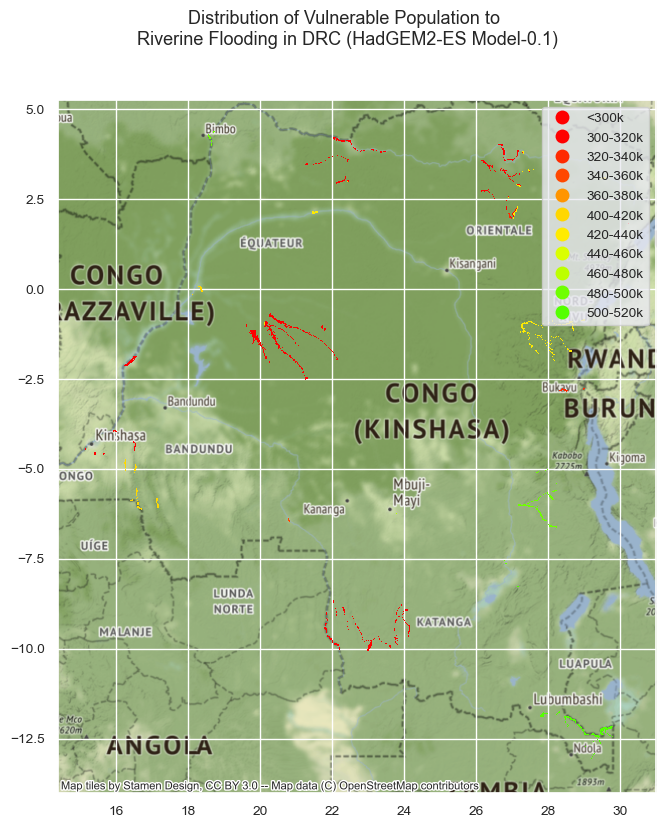

In [24]:
bins = [-1e6, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000]
labels = ['<300k', '300-320k','320-340k','340-360k','360-380k', '400-420k', 
              '420-440k', '440-460k', '460-480k', '480-500k', '500-520k']

#create a new variable with our bin labels
intersection['bin'] = pd.cut(
    intersection['population'],
    bins=bins,
    labels=labels
)

#open a new seaborn figure
sns.set(font_scale = 0.9)
fig, ax = plt.subplots(1, 1, figsize = (8, 9))

#now plot our data using pandas plot
base = intersection.plot(column = 'bin', ax = ax, cmap = 'prism', linewidth = 0, #inferno_r
    legend = True, antialiased = False)
cx.add_basemap(ax, crs = 'epsg:4326', source = cx.providers.Stamen.Terrain)

#allocate a plot title 
n = len(intersection)
name = 'Distribution of Vulnerable Population to \nRiverine Flooding in DRC (HadGEM2-ES Model-0.1)'
fig.suptitle(name)
plt.suptitle(name, fontsize = 13, wrap =True)

#specify where to write our .png file to
path = os.path.join('data', 'processed', 'COD', 'hadgem_100_pop_flood_fig.png')
fig.savefig(path)
plt.close(fig)
fig

### Quantification of the Vulnerable Population 

In this ection, we process the results from the two scenarios to generate uncertain results. The results will be plotted as bar charts in R since it has superior graphics compared to python's graphic libraries.

First we import the previously saved population and flood intersection shapefiles of the historical (*intersected_historical_flood.shp*) and RCP8.5 (*rcp8p5_population_boundary.shp*) scenario.  

In [ ]:
filename = 'intersected_historical_100_flood.shp'
filename1 = 'intersected_rcp8p5_100_flood.shp'

#Historical baseline results
path_in = os.path.join('data', 'processed', 'RWA', 
                       'hazards', 'inunriver', 
                       'intersections', filename) 
hist = gpd.read_file(path_in)

#RCP 8.5 results
path_in = os.path.join('data', 'processed', 'RWA', 
                       'hazards', 'inunriver', 
                       'intersections', filename1) 
rcp = gpd.read_file(path_in)

Next, we only pick the columns of interest. These are the region, population, flood mean depth and geometry

In [ ]:
#Select the columns to use.
hist = hist[['NAME_1_x', 'population', 'value', 'geometry']]
rcp = rcp[['NAME_1_x', 'population', 'value', 'geometry']]

We then calculate the area occupied by the vulnerable populations using the *geometry* column and then drop the geometry column since we no longer need it. 

In [ ]:
hist['area'] = hist.geometry.area
rcp['area'] = rcp.geometry.area
hist = hist.drop(['geometry'], axis=1)
rcp = rcp.drop(['geometry'], axis=1)

We then create a new column to store the scenario for each of the datapoints, i.e historical and rcp as well as the regions under which several counties in Kenya are classified under.

In [ ]:
hist[['scenario', 'region', 'period']] = ''
rcp[['scenario', 'region', 'period']] = ''
rcp.head()

We then write two generic functions that classifies each of the dataframe flood results by climatic scenario, as well as the counties into eight regions of Kenya.

However, to classify the counties, we first create 8 regions list that contain the counties and then use them within our function.

In [ ]:
coast = ['Mombasa', 'Kwale', 'Kilifi', 
         'Taita Taveta', 'Lamu', 'Tana River']

rift = ['Turkana', 'West Pokot', 'Samburu', 
        'Trans Nzoia', 'Uasin Gishu', 
        'Elgeyo Marakwet', 'Nandi', 
        'Baringo', 'Laikipia', 'Nakuru', 
        'Narok', 'Kajiado', 'Kericho', 'Bomet']

central = ['Nyandarua', 'Nyeri', 'Kirinyanga', 
           "Murang'a", 'Kiambu']

western = ['Kakamega', 'Vihiga', 'Bungoma', 'Busia']

eastern = ['Marsabit', 'Isiolo', 'Meru', 
           'Tharaka-Nithi', 'Embu', 'Kitui', 
           'Machakos', 'Makueni']

north = ['Garissa', 'Wajir', 'Mandera']

nyanza = ['Siaya', 'Kisumu', 'Homa Bay', 
          'Migori', 'Kisii', 'Nyamira']

Here is the generic function for classifying the climate scenarios.

In [ ]:
def process_scenario(dataframe, scenario):
    """
    Process the regions of counties.
    
    Parameters
    ----------
    dataframe : Dataframe
        Dataframe to process.
    scenario : string
        The scenario to be classified.
    
    Return
    ------
    df : Dataframe
        Processed dataframe
    
    """
    for i in range(len(dataframe)):
        dataframe['scenario'].loc[i] = scenario
    
    return dataframe

We then apply the function for the two dataframes.

In [ ]:
%time
historical = process_scenario(hist, 'historical')
rcp_model = process_scenario(rcp, 'rcp')

Here is the function for classifying the regions

In [ ]:
def process_regions(dataframe):
    """
    Process the regions of counties.
    
    Parameters
    ----------
    dataframe : Dataframe
        Dataframe to process.
    
    Return
    ------
    df : Dataframe
        Processed dataframe
    
    """
    for i in range(len(dataframe)):
        if dataframe["NAME_1_x"].loc[i] in rift:
            dataframe["region"].loc[i] = 'Rift Valley'
        elif dataframe["NAME_1_x"].loc[i] in western:
            dataframe["region"].loc[i] = 'Western'
        elif dataframe["NAME_1_x"].loc[i] in coast:
            dataframe["region"].loc[i] = 'Coast'
        elif dataframe["NAME_1_x"].loc[i] in central:
            dataframe["region"].loc[i] = 'Central'
        elif dataframe["NAME_1_x"].loc[i] in central:
            dataframe["region"].loc[i] = 'Central'
        elif dataframe["NAME_1_x"].loc[i] in eastern:
            dataframe["region"].loc[i] = 'Eastern'
        elif dataframe["NAME_1_x"].loc[i] in north:
            dataframe["region"].loc[i] = 'North Eastern'
        elif dataframe["NAME_1_x"].loc[i] in nyanza:
            dataframe["region"].loc[i] = 'Nyanza'
        else:
            dataframe["region"].loc[i] = 'Nairobi'
            
    return dataframe

We then apply the two functions to classify the counties into regions.

In [ ]:
%time
historical = process_regions(historical)
rcp_model = process_regions(rcp_model)

We combine the two dataframes and then save the results as a csv file.

We also specify the folder where to store the results.

In [ ]:
folder = os.path.join('..', 'Research')

In [ ]:
#Concatenate the two dataframes
results = pd.concat([historical, rcp_model]).reset_index(drop = True)
results = results.dropna()
results = results.assign(period = 0.1)

#Name of your final results
filename = "quantity_2_results.csv"

#Folder where to save the results
if not os.path.exists(folder):
    os.makedirs(folder)
path_out = os.path.join(folder, filename)
results.to_csv(path_out)

The results are then exported for plotting in R. The R code used in generating the plots is attached

In [ ]:
filename = 'quantity_results.csv'
filename1 = 'quantity_2_results.csv'
path_in = os.path.join('..', 'Research', filename) 
path_in2 = os.path.join('..', 'Research', filename1)
df = pd.read_csv(path_in)
df1 = pd.read_csv(path_in2)
results = pd.concat([df, df1]).reset_index(drop = True)
filename = "full_quantity_results.csv"
if not os.path.exists(folder):
    os.makedirs(folder)
path_out = os.path.join(folder, filename)
results.to_csv(path_out)